In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahooquery import Ticker

# Coleta dos dados

CSV retirado do site [fundamentus](https://fundamentus.com.br/detalhes.php)

Adicionalmente será utilizada a biblioteca [YahooQuery](https://yahooquery.dpguthrie.com/) para coleta de dados dinâmicos realacionados a cotação

In [2]:
df = pd.read_csv('../data/2020_10_11_fundamentus.csv', index_col='ticker')

In [3]:
df.replace([np.inf, -np.inf], np.nan)
df.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,CRES_REC_(5A),ROIC,LIQUIDEZ_CORR,SETOR,SUBSETOR,DEPOSITOS,CART_DE_CREDITO,RESULT_INT_FINANC,REC_SERVICOS
ticker,,,,,,,,,,,,,,,,,,,
AALR3,2.618910e+09,9.017330e+08,3.253200e+08,5.764130e+08,6.355580e+08,1.179760e+09,9.147390e+08,-2.432000e+06,-8.448000e+07,1.182930e+08,-0.040,-0.001,0.87,SAUDE,SERVICOS_MEDICO_-_HOSPITALARES_ANALISES_E_DIAG...,NaN,NaN,NaN,NaN
ABCB3,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABCB4,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABEV3,1.213930e+11,6.782830e+09,1.748380e+10,-1.070090e+10,3.626810e+10,7.392280e+10,5.203240e+10,1.322820e+10,8.915960e+09,1.573510e+10,0.030,0.146,1.24,BEBIDAS,CERVEJAS_E_REFRIGERANTES,NaN,NaN,NaN,NaN
ABYA3,9.782870e+08,3.831590e+08,2.955600e+07,3.536030e+08,4.982220e+08,2.920600e+08,2.506570e+08,2.580200e+07,-2.398000e+06,1.049060e+08,0.164,0.028,2.09,CONSTRUCAO_E_ENGENHARIA,CONSTRUCAO_CIVIL,NaN,NaN,NaN,NaN


In [4]:
df.dtypes

ATIVO                float64
DIV_BRUTA            float64
DISPONIBILIDADES     float64
DIV_LIQUIDA          float64
ATIVO_CIRCULANTE     float64
PATRIM_LIQ           float64
RECEITA_LIQUIDA      float64
EBIT                 float64
LUCRO_LIQUIDO        float64
NRO_ACOES            float64
CRES_REC_(5A)        float64
ROIC                 float64
LIQUIDEZ_CORR        float64
SETOR                 object
SUBSETOR              object
DEPOSITOS            float64
CART_DE_CREDITO      float64
RESULT_INT_FINANC    float64
REC_SERVICOS         float64
dtype: object

### Adicionando indicadores fundamentalistas em função da cotação atual

O método `Ticker.summary_detail` retorna uma série de atributos referentes a cotação do papel em questão. O crawler do fundamentus ainda retorna algums papéis que já tiveram sua *Oferta Pública de Aquisição* (OPA) e/ou não estão mais na B3

É necessário filtrar esses ativos com ajuda da classe `Ticker`

In [5]:
# https://yahooquery.dpguthrie.com/guide/ticker/intro/
tickers = Ticker(' '.join(f'{ticker}.SA' for ticker in df.index), asynchronous=True)

In [6]:
%%time
# o atributo sumary_detail retorna um dicionario que tem como chaves os tickers (seguidos de .SA) dos papeis da B3
# quando um ticker nao esta mais disponivel (acao nao existe mais na b3) o valor dessa chave eh uma string
# aqui eh feita a filtragem baseada nesse criterio

summary_detail = tickers.summary_detail
summary_detail = [dict(ticker=k.replace('.SA', ''), **summary_detail[k]) for k in summary_detail.keys()
                 if isinstance(summary_detail[k], dict) and 'previousClose' in summary_detail[k]]

CPU times: user 4.29 s, sys: 276 ms, total: 4.57 s
Wall time: 23 s


In [7]:
summaries = pd.DataFrame(summary_detail)
summaries = summaries.set_index('ticker')

In [8]:
summaries.head()

,maxAge,priceHint,previousClose,open,dayLow,dayHigh,regularMarketPreviousClose,regularMarketOpen,regularMarketDayLow,regularMarketDayHigh,...,fiftyDayAverage,twoHundredDayAverage,trailingAnnualDividendRate,trailingAnnualDividendYield,currency,fromCurrency,toCurrency,lastMarket,algorithm,tradeable
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,1,2,12.31,12.35,12.19,12.79,12.31,12.35,12.19,12.79,...,12.897353,13.694123,0.490,0.039805,BRL,None,None,None,None,False
ADHM3,1,4,2.01,2.01,1.97,2.02,2.01,2.01,1.97,2.02,...,2.077941,2.283786,NaN,NaN,BRL,None,None,None,None,False
ABEV3,1,2,13.68,13.64,13.54,13.93,13.68,13.64,13.54,13.93,...,12.722571,12.947063,0.491,0.035892,BRL,None,None,None,None,False
AALR3,1,2,10.71,10.72,10.72,11.28,10.71,10.72,10.72,11.28,...,11.355429,10.683287,0.085,0.007937,BRL,None,None,None,None,False
AFLT3,1,2,9.75,9.74,9.74,9.89,9.75,9.74,9.74,9.89,...,9.998823,9.262643,0.000,0.000000,BRL,None,None,None,None,False


In [9]:
print(len(summaries))
summaries.describe()

457


,maxAge,priceHint,previousClose,open,dayLow,dayHigh,regularMarketPreviousClose,regularMarketOpen,regularMarketDayLow,regularMarketDayHigh,...,bidSize,askSize,marketCap,fiftyTwoWeekLow,fiftyTwoWeekHigh,priceToSalesTrailing12Months,fiftyDayAverage,twoHundredDayAverage,trailingAnnualDividendRate,trailingAnnualDividendYield
count,457.0,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,...,390.0,390.0,4.480000e+02,457.000000,457.000000,427.000000,456.000000,456.000000,301.000000,301.000000
mean,1.0,2.293217,27.227823,16.618665,26.119059,26.691094,27.227823,16.618665,26.119059,26.691094,...,0.0,0.0,1.346299e+10,16.064448,43.002717,452.702919,27.709598,25.746086,1.140983,0.045399
std,0.0,0.708205,40.742977,20.441441,40.136639,40.274839,40.742977,20.441441,40.136639,40.274839,...,0.0,0.0,3.638415e+10,24.687346,73.955436,7891.742352,39.833788,37.821780,6.400923,0.144611
min,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000e+00,0.000000,0.620000,-10.312549,0.620000,0.620000,0.000000,0.000000
25%,1.0,2.000000,7.900000,2.310000,7.050000,7.480000,7.900000,2.310000,7.050000,7.480000,...,0.0,0.0,3.499008e+08,4.000000,12.010000,0.722577,7.893691,7.290110,0.102000,0.007171
50%,1.0,2.000000,16.850000,10.220000,16.420000,16.900000,16.850000,10.220000,16.420000,16.900000,...,0.0,0.0,2.288740e+09,9.150000,25.100000,1.440551,17.197112,15.745462,0.410000,0.019872
75%,1.0,2.000000,29.930000,22.510000,29.770000,30.400000,29.930000,22.510000,29.770000,30.400000,...,0.0,0.0,9.513256e+09,20.000000,45.000000,3.275502,31.234019,29.457271,1.090000,0.043705
max,1.0,4.000000,450.000000,177.360000,450.000000,450.000000,450.000000,177.360000,450.000000,450.000000,...,0.0,0.0,3.160024e+11,299.980000,920.000000,162355.620000,408.570280,457.468840,110.507000,2.302229


In [10]:
# filtrando os ativos que não pertencem mais a B3 ou não estão disponíveis no Fundamentus
df_clean = df[pd.Series(df.index, index=df.index).isin(summaries.index)]

# e adicionando os campos COTACAO e DY retornados pelo yahoo finance
df_clean = df_clean.join(summaries[['dividendYield', 'previousClose']]).rename(columns={
    'previousClose': 'COTACAO',
    'dividendYield': 'DY'
})

Calculando os indicadores fundamentalistas

In [11]:
# LPA: Lucro por Acoes
df_clean['LPA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['NRO_ACOES']

# VPA: Valor Patrimonial por Acao
df_clean['VPA'] = df_clean['PATRIM_LIQ'] / df_clean['NRO_ACOES']

# P/L: Preço sobre Lucro
df_clean['P/L'] = df_clean['COTACAO'] / df_clean['LPA']

# P/VPA: Preço sobre Valor Patrimonial
df_clean['P/VP'] = df_clean['COTACAO'] / df_clean['VPA']

# P/EBIT: Preço sobre EBIT
df_clean['P/EBIT'] = df_clean['COTACAO'] / (df_clean['EBIT'] / df_clean['NRO_ACOES'])

# MARKET_CAP: valor total das acoes ou valor de mercado
df_clean['MARKET_CAP'] = df_clean['COTACAO'] * df_clean['NRO_ACOES']

# EV: Enterprise Value == market cap - divida liquida
df_clean['EV'] = df_clean['MARKET_CAP'] - df_clean['DIV_LIQUIDA']

# EV/EBIT: Enterprise Value sobre EBIT
df_clean['EV/EBIT'] = df_clean['EV'] / df_clean['EBIT']

# MARGEM_EBIT: EBIT/RECEITA_LIQUIDA
df_clean['MARGEM_EBIT'] = df_clean['EBIT'] / df_clean['RECEITA_LIQUIDA']

# MARGEM_LIQUIDA: LUCRO_LIQUIDO/RECEITA_LIQUIDA
df_clean['MARGEM_LIQUIDA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['RECEITA_LIQUIDA']

# ROE: LUCRO_LIQUIDO/PATRIM_LIQ
df_clean['ROE'] = df_clean['LUCRO_LIQUIDO'] / df_clean['PATRIM_LIQ']

# DIV_BRUT/PATR_LIQ
df_clean['DIV_BRUT/PATR_LIQ'] = df_clean['DIV_BRUTA'] / df_clean['PATRIM_LIQ']

In [12]:
df_clean.loc['BBSE3'] # Exemplo de Itausa, holding a que pertence o Itau

ATIVO                                    0
DIV_BRUTA                                0
DISPONIBILIDADES                         0
DIV_LIQUIDA                              0
ATIVO_CIRCULANTE                         0
PATRIM_LIQ                               0
RECEITA_LIQUIDA                          0
EBIT                                     0
LUCRO_LIQUIDO                            0
NRO_ACOES                            2e+09
CRES_REC_(5A)                          NaN
ROIC                                   NaN
LIQUIDEZ_CORR                          NaN
SETOR                PREVIDENCIA_E_SEGUROS
SUBSETOR                       SEGURADORAS
DEPOSITOS                              NaN
CART_DE_CREDITO                        NaN
RESULT_INT_FINANC                      NaN
REC_SERVICOS                           NaN
DY                                  0.1151
COTACAO                               24.5
LPA                                      0
VPA                                      0
P/L        

# Definição de tipos

Dessa forma temos um dataset construido, com possibilidade de ter os dados de balanço patrimonial atualizados através do crawler e os dados de mercado através da api yahooquery

O dataset final tem 32 atributos, sendo 30 numéricos e 2 categóricos como mostrado abaixo

In [13]:
acoes = df_clean
# mudando o tipo de setor e subsetor de antemão
acoes['SETOR'] = acoes['SETOR'].astype('category')
acoes['SUBSETOR'] = acoes['SUBSETOR'].astype('category')
acoes.shape

(457, 33)

In [14]:
acoes.dtypes

ATIVO                 float64
DIV_BRUTA             float64
DISPONIBILIDADES      float64
DIV_LIQUIDA           float64
ATIVO_CIRCULANTE      float64
PATRIM_LIQ            float64
RECEITA_LIQUIDA       float64
EBIT                  float64
LUCRO_LIQUIDO         float64
NRO_ACOES             float64
CRES_REC_(5A)         float64
ROIC                  float64
LIQUIDEZ_CORR         float64
SETOR                category
SUBSETOR             category
DEPOSITOS             float64
CART_DE_CREDITO       float64
RESULT_INT_FINANC     float64
REC_SERVICOS          float64
DY                    float64
COTACAO               float64
LPA                   float64
VPA                   float64
P/L                   float64
P/VP                  float64
P/EBIT                float64
MARKET_CAP            float64
EV                    float64
EV/EBIT               float64
MARGEM_EBIT           float64
MARGEM_LIQUIDA        float64
ROE                   float64
DIV_BRUT/PATR_LIQ     float64
dtype: obj

# Tratamento de dados ausentes

- É possível perceber que há uma divisão entre pelo menos dois tipos distintos de ações dado que o total é 457 e vários atributos estão com 42 ou 415 dados ausentes. Ou seja, há uma divisão clara, provavelmente entre empresas do subsetor bancário e as outras.

<AxesSubplot:>

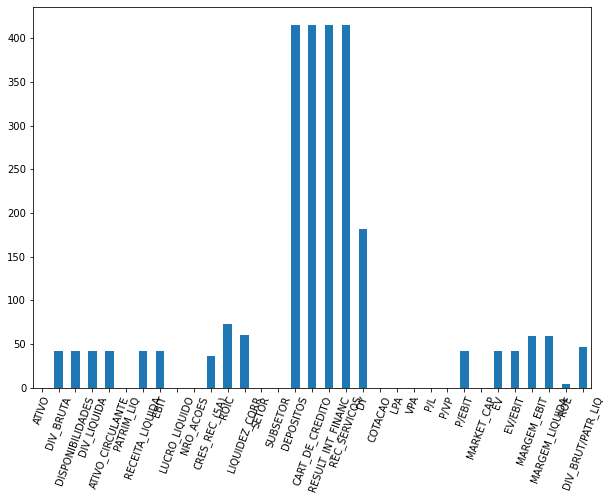

In [15]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

(54, 33)
(54, 33)


<AxesSubplot:>

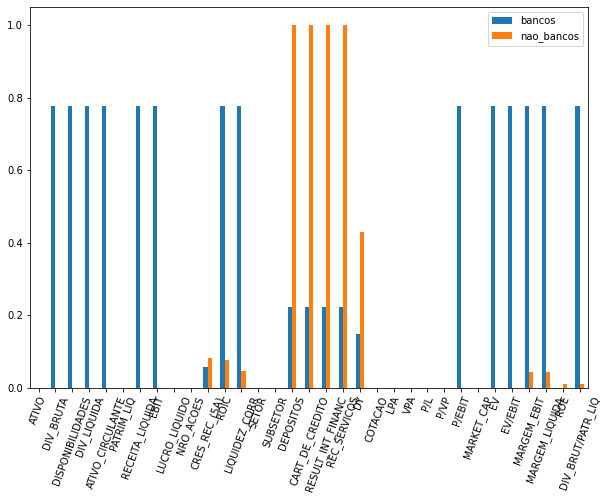

In [16]:
bancos = acoes[acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

comuns = acoes[~acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

pd.DataFrame({'bancos':bancos.isna().sum()/len(bancos), 'nao_bancos':comuns.isna().sum()/len(comuns)}).plot.bar(rot=70, figsize=(10, 7))

A estratégia de inputação dos dados ausentes aqui vai se basear no subsetor de cada ativo, mais especificamente nessa divisião entre setor bancário/outros setores.

Para os que pertencem ao setor bancário, os atributos que são característicos desse setor (`DEPOSITOS`, `CART_DE_CREDITO`, etc) serão imputados com zero juntamente com os que não pertencem a esse setor pois são apenas 3 empresas (`BRGE`, `ITSA`, `RPAD`), que na verdade são holdings ou consórcios financeiros que possuem valores ausentes, então serão tratadas como empresas comuns.
O contrário também será aplicado.

In [17]:
# AS EMPRESAS QUE ESTAO NO SUBSETOR BANCARIO E POSSUEM VALORES AUSENTES PARA ATRIBUTOS
# CARACTERISTICOS DESSE SUBSETOR SÃO APENAS 3
bancos[(bancos['DEPOSITOS'].isna()) | (bancos['CART_DE_CREDITO'].isna())
       | (bancos['RESULT_INT_FINANC'].isna()) | (bancos['REC_SERVICOS'].isna())].index

Index(['BRGE11', 'BRGE12', 'BRGE3', 'BRGE5', 'BRGE6', 'BRGE7', 'BRGE8',
       'ITSA3', 'ITSA4', 'RPAD3', 'RPAD5', 'RPAD6'],
      dtype='object', name='ticker')

In [18]:
attrs_bancos = ['DEPOSITOS', 'CART_DE_CREDITO', 'RESULT_INT_FINANC', 'REC_SERVICOS']

bancos[attrs_bancos] = bancos[attrs_bancos].fillna(value=0)
comuns[attrs_bancos] = comuns[attrs_bancos].fillna(value=0)


attrs_comuns = ['DIV_BRUTA', 'DISPONIBILIDADES', 'DIV_LIQUIDA', 'ATIVO_CIRCULANTE', 'PATRIM_LIQ',
                'RECEITA_LIQUIDA', 'EBIT', 'ROIC', 'LIQUIDEZ_CORR', 'P/EBIT', 'EV', 'EV/EBIT',
                'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'DIV_BRUT/PATR_LIQ']

bancos[attrs_comuns] = bancos[attrs_comuns].fillna(value=0)

/home/adilson/.anaconda3/envs/if697/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

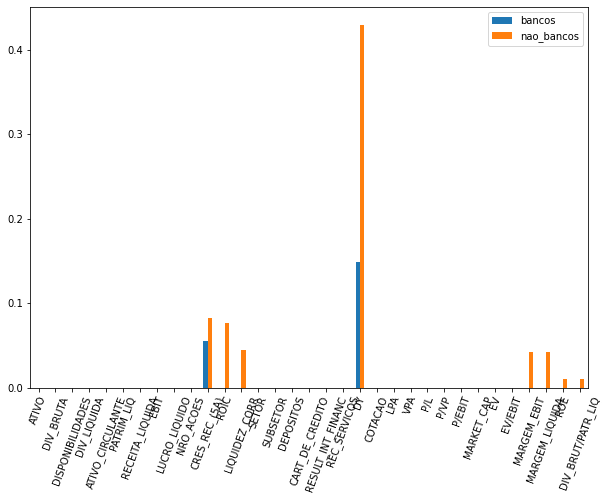

In [19]:
pd.DataFrame(
    {'bancos': bancos.isna().sum()/len(bancos), 'nao_bancos': comuns.isna().sum()/len(comuns)}
).plot.bar(rot=70, figsize=(10, 7))

O DY (Dividend Yield) especificamente será imputado com valor zero, há empresas que pagam dividendo e outras que não.

In [20]:
acoes = pd.concat([bancos, comuns])

In [21]:
acoes['DY'] = acoes['DY'].fillna(0)

<AxesSubplot:>

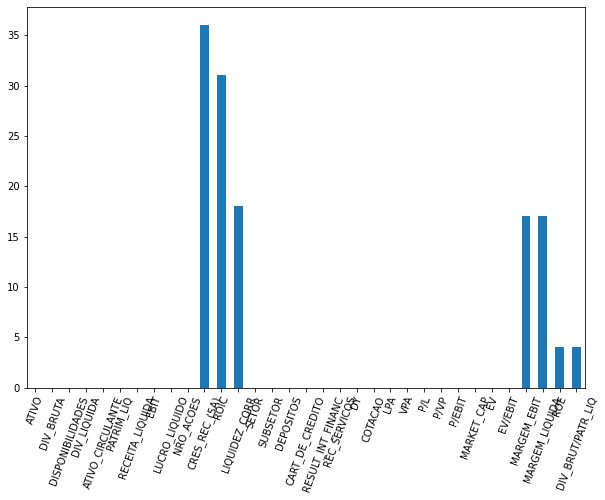

In [22]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

**Para valores ausentes restantes** será utilizado o **KNNImputer** do sklearn, e para isso é preciso codificar numericamente os atributos categóricos e normalizar os valores para a extensão dos atributos não influenciar o cálculo da distância no KNN

In [23]:
# One hot encoding com .get_dummies
acoes_c = pd.get_dummies(acoes, drop_first=True)
acoes_c = acoes_c.replace([np.inf, -np.inf], np.nan)
acoes_c.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0,0,0,0,0,0,0,0,0,0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0,0,0,0,0,0,0,0,0,0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0


In [24]:
acoes_norm = (acoes_c - acoes_c.min()) / (acoes_c.max() - acoes_c.min())
acoes_norm.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,0.028024,0.0,0.0,0.033805,0.0,0.066841,0.004307,0.031023,0.638280,0.013876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,0.011521,0.0,0.0,0.033805,0.0,0.059894,0.004307,0.031023,0.636544,0.001883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.000000,0.0,0.0,0.033805,0.0,0.461392,0.004307,0.031023,0.929623,0.182103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.004307,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.004307,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)

In [26]:
acoes_one_hot = pd.DataFrame(imputer.fit_transform(acoes_norm), index=acoes_norm.index, columns=acoes_norm.columns)

Desfazendo a normalização

In [27]:
acoes_one_hot = acoes_one_hot * (acoes_c.max() - acoes_c.min()) + acoes_c.min()

In [28]:
acoes_one_hot.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# sem valores vazios :)

acoes_one_hot.isna().sum()[acoes_one_hot.isna().sum() > 0]

Series([], dtype: int64)

In [30]:
# desfazendo one hot encoding
acoes_full = acoes_one_hot.copy()
acoes_full['SETOR'] = acoes['SETOR'].astype('category')
acoes_full['SUBSETOR'] = acoes['SUBSETOR'].astype('category')

acoes_full = acoes_full.drop(columns=[col for col in acoes_full if col.startswith('SETOR_') or col.startswith('SUBSETOR_')])

In [31]:
acoes_full

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_BRUT/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.093300e+09,0.000000e+00,0.0,4.187330e+08,2.183590e+08,...,0.000000,2.687999e+09,0.000000e+00,0.000000,0.000000,-5.684342e-14,0.102297,0.000000,FINANCEIROS,BANCOS
BAZA3,2.051230e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.316530e+09,0.000000e+00,0.0,3.250920e+08,2.964600e+07,...,0.000000,1.153229e+09,0.000000e+00,0.000000,0.000000,-5.684342e-14,0.140336,0.000000,FINANCEIROS,BANCOS
BBAS3,1.780470e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.050070e+11,0.000000e+00,0.0,1.612730e+10,2.865420e+09,...,0.000000,8.954438e+10,0.000000e+00,0.000000,0.000000,-5.684342e-14,0.153583,0.000000,FINANCEIROS,BANCOS
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.0,1.760820e+10,8.870210e+09,...,0.000000,1.703080e+11,0.000000e+00,0.000000,0.000000,-5.684342e-14,0.130302,0.000000,FINANCEIROS,BANCOS
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.0,1.760820e+10,8.870210e+09,...,0.000000,1.831698e+11,0.000000e+00,0.000000,0.000000,-5.684342e-14,0.130302,0.000000,FINANCEIROS,BANCOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WIZS3,6.568160e+08,1.100000e+05,1.216680e+08,-1.215580e+08,2.203580e+08,2.714090e+08,6.818470e+08,385605000.0,1.927290e+08,1.599070e+08,...,3.918832,1.511121e+09,1.632679e+09,4.234072,0.565530,2.826573e-01,0.710105,0.000405,PREVIDENCIA_E_SEGUROS,CORRETORAS_DE_SEGUROS
WLMM3,5.782710e+08,3.108500e+07,1.201280e+08,-8.904300e+07,2.548540e+08,4.396770e+08,1.039280e+09,54744000.0,5.403700e+07,3.641470e+07,...,10.775941,5.899181e+08,6.789611e+08,12.402476,0.052675,5.199465e-02,0.122902,0.070700,COMERCIO,MATERIAL_DE_TRANSPORTE
WLMM4,5.782710e+08,3.108500e+07,1.201280e+08,-8.904300e+07,2.548540e+08,4.396770e+08,1.039280e+09,54744000.0,5.403700e+07,3.641470e+07,...,12.345770,6.758568e+08,7.648998e+08,13.972304,0.052675,5.199465e-02,0.122902,0.070700,COMERCIO,MATERIAL_DE_TRANSPORTE


# Limpeza dos dados

Ainda temos 147 atributos depois do *one hot encoding*

Para detectar outliers com esse número de features será utilizado o Isolation Forest e o Local Outlier Factor, já que eles não são paramétricos

In [32]:
from sklearn.ensemble import IsolationForest

In [33]:
iforest = IsolationForest(contamination=.01, random_state=0)
acoes_one_hot[pd.Series(iforest.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VALE3,4.553030e+11,1.016080e+11,6.633310e+10,3.527500e+10,1.111950e+11,1.869590e+11,1.533680e+11,6.342340e+10,6.407460e+09,5.284470e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=25, contamination=0.01)

acoes_one_hot[pd.Series(lof.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBAS3,1.780470e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.050070e+11,0.000000e+00,0.000000e+00,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dada a relevância dos ativos dados como outliers pelo Isolation Forest e Local Outlier Factor, não será feita a remoção desses outliers do dataset

# Estatísticas Descritivas

# Testes de Hipótese